In [63]:
from sklearn.model_selection import train_test_split, KFold 
import pickle 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
%matplotlib inline

from sklearn.naive_bayes import BernoulliNB, GaussianNB


In [64]:
with open('//Users/adelweiss/Documents/Project/Project 3/Notebooks/df.pickle','rb') as read_file:
    df = pickle.load(read_file)

In [65]:
df

,gender,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms,no_show,schedule_hour,schedule_day,appointment_day,day_difference,appointment_weekday,schedule_weekday,prior_appointments,prior_noshows,total_conditions
2155,1,25,0,0,0,0,0,1,1,16,29,29,31,5.0,2.0,0,0,0
2156,1,49,0,0,0,0,0,0,0,17,28,29,1,5.0,4.0,0,0,0
2159,1,58,0,0,0,0,0,1,0,10,29,29,31,5.0,2.0,0,0,0
2162,0,23,0,0,0,0,0,1,0,10,29,29,31,5.0,2.0,0,0,0
2163,0,41,0,0,0,0,0,0,0,15,29,29,0,5.0,5.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92055,0,24,0,0,0,0,0,0,0,15,8,8,0,3.0,3.0,0,0,0
99217,1,54,0,1,0,0,0,0,0,17,6,8,2,3.0,1.0,1,0,1
99218,1,50,0,1,0,0,0,0,0,17,6,8,2,3.0,1.0,0,0,1
99224,1,64,0,1,1,0,0,0,0,17,6,8,2,3.0,1.0,2,0,2


In [4]:
# age_range = range(0,18)
# df['age'].replace(to_replace=age_range, value=np.nan, inplace = True)
# df.dropna(inplace = True)

# EDA

In [5]:
df.no_show.value_counts(normalize=True) ##about 20% of patients won't show up

0    0.803511
1    0.196489
Name: no_show, dtype: float64

In [6]:
df_eda = df.copy()

In [7]:
### https://towardsdatascience.com/attribute-relevance-analysis-in-python-iv-and-woe-b5651443fc04
### referencing this articles for WoE and IV 

In [8]:
### Binning categorical data 

df_eda['age_bins'] = pd.qcut(df_eda['age'],10, duplicates='drop')
df_eda['schedule_hour_bins'] = pd.qcut(df_eda['schedule_hour'],3, duplicates='drop')
df_eda['schedule_day_bins'] = pd.qcut(df_eda['schedule_day'],4, duplicates='drop')
df_eda['appointment_day_bins'] = pd.qcut(df_eda['appointment_day'],4, duplicates='drop')
df_eda['day_difference_bins'] = pd.qcut(df_eda['day_difference'],5, duplicates='drop')
df_eda['prior_appointments_bins'] = pd.qcut(df_eda['prior_appointments'], 4, duplicates = 'drop')


In [9]:
df_eda.drop(columns = ['age', 'schedule_hour', 'schedule_day', 'appointment_day', 'day_difference',
                       'prior_appointments'], inplace=True)

In [10]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Show': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'No_show': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_show'] = dset['Show'] / dset['Show'].sum()
    dset['Distr_no_show'] = dset['No_show'] / dset['No_show'].sum()
    dset['WoE'] = np.log(dset['Distr_show'] / dset['Distr_no_show'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_show'] - dset['Distr_no_show']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [11]:
for col in df_eda.columns:
    if col == 'no_show': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        df_woe_iv, iv = calculate_woe_iv(df_eda, col, 'no_show')
        print(df_woe_iv)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: gender
   Value    All   Show  No_show  Distr_show  Distr_no_show       WoE        IV
1      0  14316  11495     2821    0.310844       0.311954 -0.003566  0.000004
0      1  31707  25485     6222    0.689156       0.688046  0.001612  0.000002
IV score: 0.00


WoE and IV for column: scholarship
   Value    All   Show  No_show  Distr_show  Distr_no_show       WoE        IV
1      1   4034   3068      966    0.082964       0.106823 -0.252769  0.006031
0      0  41989  33912     8077    0.917036       0.893177  0.026362  0.000629
IV score: 0.01


WoE and IV for column: hypertension
   Value    All   Show  No_show  Distr_show  Distr_no_show       WoE        IV
0      0  33811  26730     7081    0.722823       0.783037 -0.080015  0.004818
1      1  12212  10250     1962    0.277177       0.216963  0.244927  0.014748
IV score: 0.02


WoE and IV for column: diabetes
   Value    All   Show  No_show  Distr_show  Distr_no_show       WoE        IV
0      0  41633  33326    

//anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


    Value    All   Show  No_show  Distr_show  Distr_no_show       WoE  \
7       6     10      2        8    0.000054       0.000885 -2.794681   
4       3    126     38       88    0.001028       0.009731 -2.248137   
2       2    406    124      282    0.003353       0.031184 -2.230012   
1       1   1802    569     1233    0.015387       0.136349 -2.181711   
5       4     42     16       26    0.000433       0.002875 -1.893894   
3       5     17      8        9    0.000216       0.000995 -1.526169   
6       7      6      3        3    0.000081       0.000332 -1.408386   
8       9      3      0        3    0.000000       0.000332  0.000000   
9       8      1      0        1    0.000000       0.000111  0.000000   
10     10      2      0        2    0.000000       0.000221  0.000000   
0       0  43608  36220     7388    0.979448       0.816986  0.181368   

          IV  
7   0.002321  
4   0.019567  
2   0.062064  
1   0.263904  
5   0.004626  
3   0.001189  
6   0.000353  
8  

In [12]:
### variables to drop IV<0.02. gender, scholarship, alcoholism, 
### handicap, appointment_weekday, schedule_weekday, total_conditions
### appointment_day, prior_appointments 

In [66]:
df.drop(columns= ['gender', 'scholarship', 'alcoholism', 'handicap', 'appointment_weekday', 'schedule_weekday',
                 'total_conditions', 'appointment_day', 'prior_appointments'], inplace = True)

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


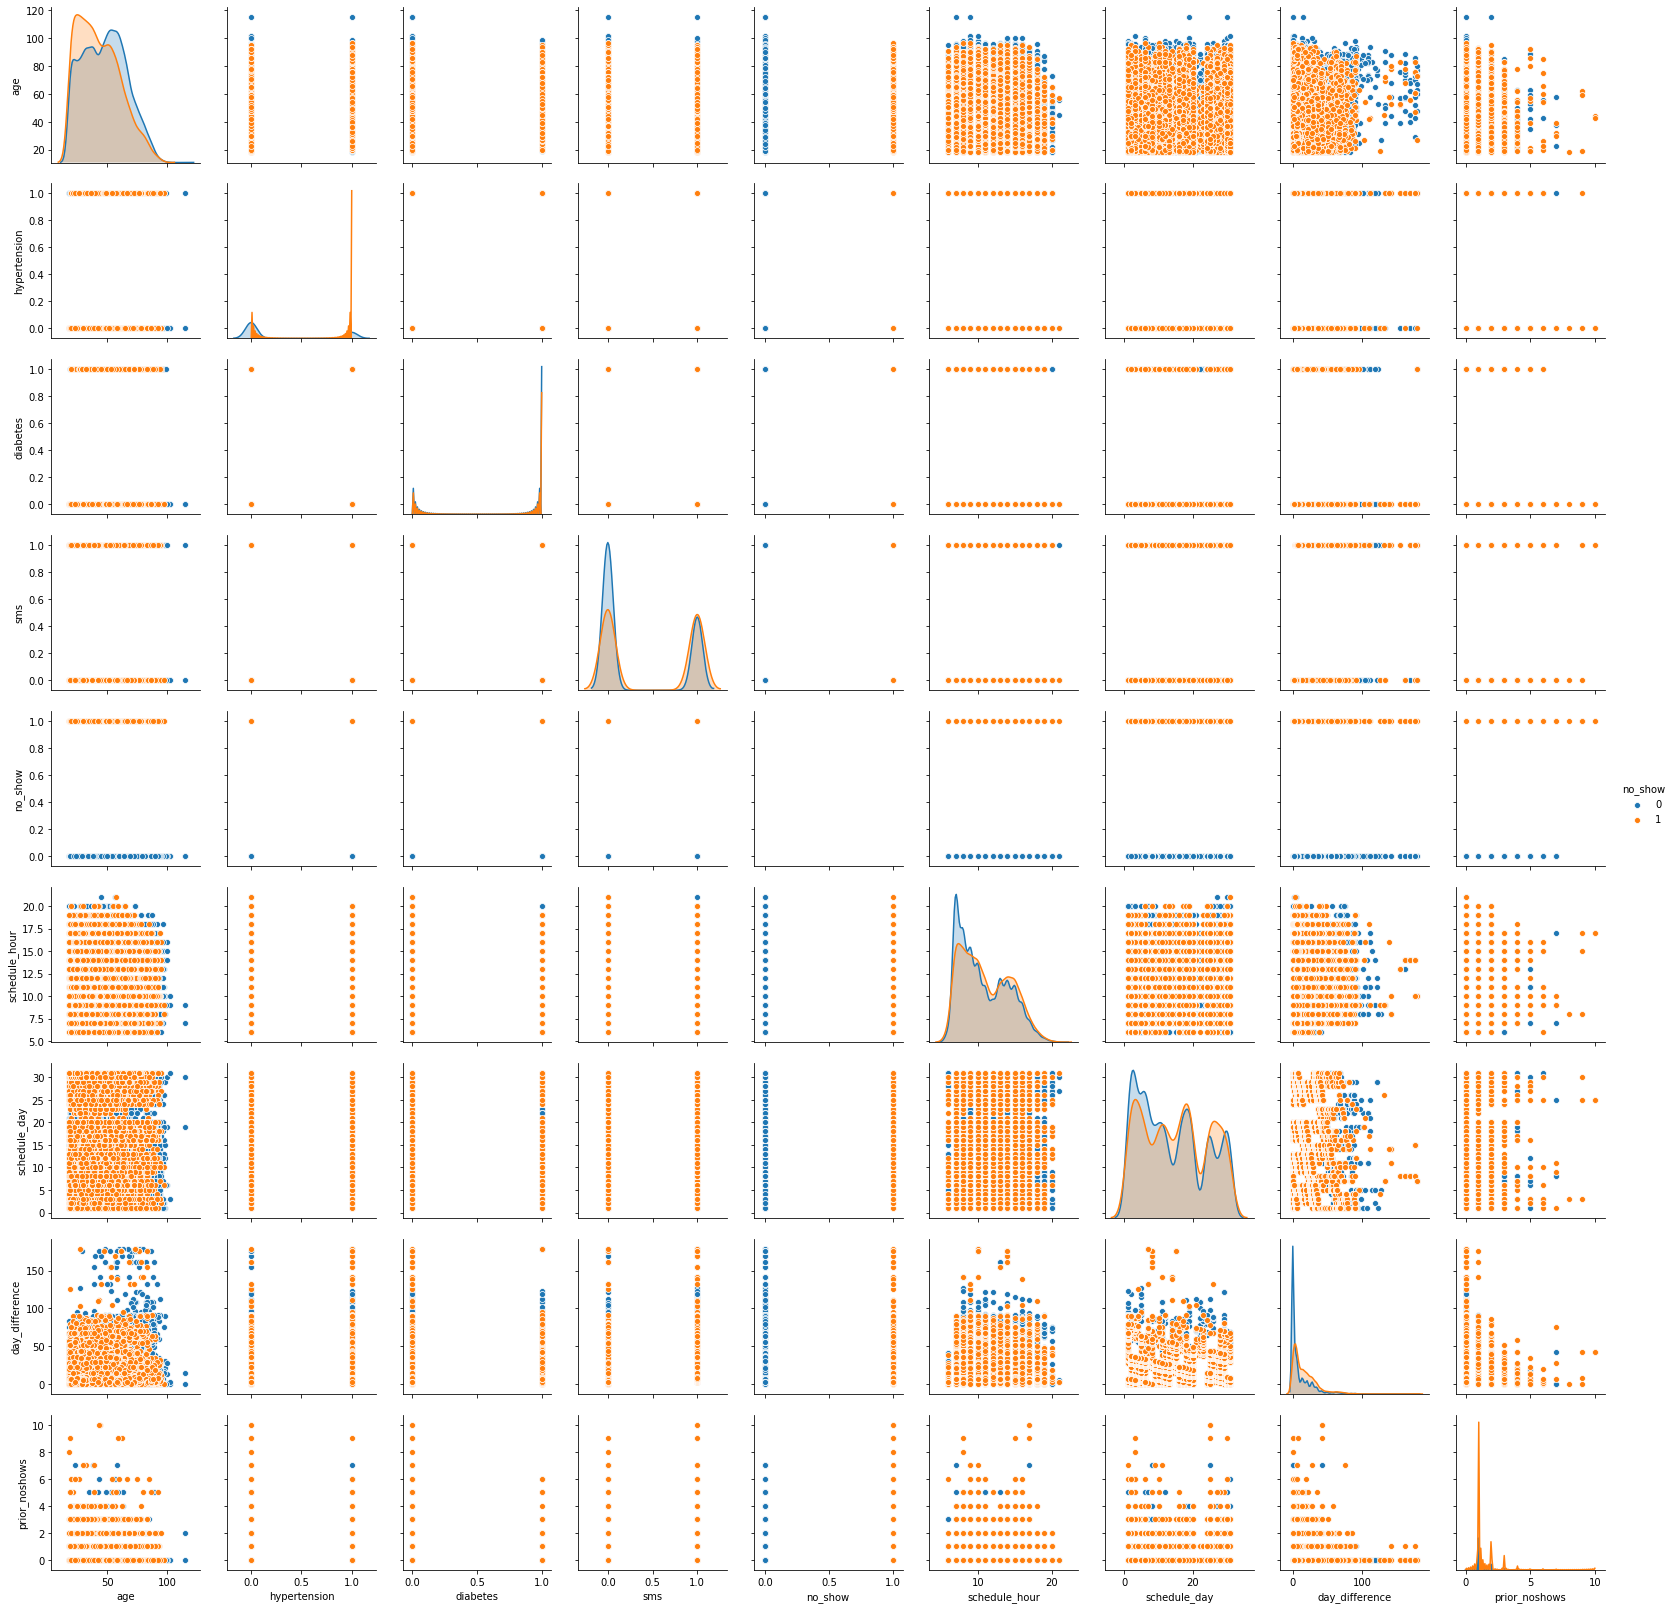

In [13]:
sns.pairplot(df, hue='no_show')

In [67]:
df.corr()

,age,hypertension,diabetes,sms,no_show,schedule_hour,schedule_day,day_difference,prior_noshows
age,1.000000,0.513227,0.293648,0.020066,-0.067767,0.008528,-0.010225,0.043063,-0.020292
hypertension,0.513227,1.000000,0.427526,-0.009774,-0.049219,-0.038191,-0.002418,-0.017008,-0.016036
diabetes,0.293648,0.427526,1.000000,-0.015796,-0.022182,-0.015025,-0.009558,-0.028707,-0.007675
sms,0.020066,-0.009774,-0.015796,1.000000,0.130668,0.063890,0.142618,0.407521,0.034198
no_show,-0.067767,-0.049219,-0.022182,0.130668,1.000000,0.066919,0.051479,0.189410,0.227906
schedule_hour,0.008528,-0.038191,-0.015025,0.063890,0.066919,1.000000,0.017313,0.091690,0.031788
schedule_day,-0.010225,-0.002418,-0.009558,0.142618,0.051479,0.017313,1.000000,0.044900,0.002331
day_difference,0.043063,-0.017008,-0.028707,0.407521,0.189410,0.091690,0.044900,1.000000,0.021117
prior_noshows,-0.020292,-0.016036,-0.007675,0.034198,0.227906,0.031788,0.002331,0.021117,1.000000


# Train-Test Split 

In [68]:
X, y = df.drop(['no_show'],axis=1), df['no_show'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
X_train, y_train = np.array(X_train), np.array(y_train) 
kf = KFold(n_splits=5, shuffle=True, random_state = 19)

## Log Regression

### K-fold cross validation

In [69]:
log_accuracy = []
log_recall = []
log_precision = []

for train, val in kf.split(X_train, y_train):
    X_trainfold, y_trainfold = X_train[train], y_train[train]
    X_valfold, y_valfold = X_train[val], y_train[val] 
    
    log_reg = LogisticRegression(solver= 'liblinear')
    
    scaler = StandardScaler()
    scaled_X_trainfold = scaler.fit_transform(X_trainfold)
    scaled_X_valfold = scaler.transform(X_valfold)
    
    log_reg.fit(scaled_X_trainfold, y_trainfold)
    #y_predict = (log_reg.predict_proba(scaled_X_valfold)[:,1] > 0.22)
    y_predict = log_reg.predict(scaled_X_valfold)
    log_accuracy.append(accuracy_score(y_valfold, y_predict))
    log_recall.append(recall_score(y_valfold, y_predict))
    log_precision.append(precision_score(y_valfold, y_predict))

In [70]:
print(log_accuracy)
print(log_recall)
print(log_precision)

[0.812305530462712, 0.8165211281742447, 0.8170229850446653, 0.8123870708693034, 0.8124874523188115]
[0.13006923837784373, 0.1342828077314344, 0.13550687722873153, 0.13117206982543642, 0.12673267326732673]
[0.7032085561497327, 0.676923076923077, 0.6785714285714286, 0.6743589743589744, 0.7111111111111111]


In [71]:
f1_score(y_valfold,y_predict)

0.21512605042016808

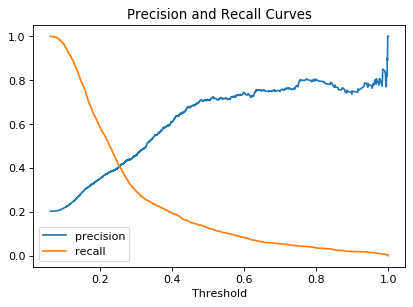

In [72]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_valfold, log_reg.predict_proba(scaled_X_valfold)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold')
plt.title('Precision and Recall Curves');

ROC AUC score =  0.7128429567333465


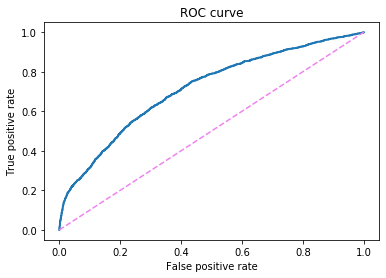

In [73]:
fpr, tpr, thresholds = roc_curve(y_valfold, log_reg.predict_proba(scaled_X_valfold)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_valfold, log_reg.predict_proba(scaled_X_valfold)[:,1]))

In [ ]:
### don't think we will get very good results even if we tune this 

### KNN 

In [74]:
knn_accuracy = []
knn_recall = []
knn_precision = []

for train, val in kf.split(X_train, y_train):
    X_trainfold, y_trainfold = X_train[train], y_train[train]
    X_valfold, y_valfold = X_train[val], y_train[val]
    
    knn = KNeighborsClassifier(n_neighbors=27) ###one less than optimal
    
    scaler = StandardScaler()
    scaled_X_trainfold = scaler.fit_transform(X_trainfold)
    scaled_X_valfold = scaler.transform(X_valfold)
    
    knn.fit(scaled_X_trainfold, y_trainfold)
    y_predict = knn.predict(scaled_X_valfold)
    
    knn_accuracy.append(accuracy_score(y_valfold, y_predict))
    knn_recall.append(recall_score(y_valfold, y_predict))
    knn_precision.append(precision_score(y_valfold, y_predict))
    

In [78]:
print(np.mean(knn_accuracy))
print(np.mean(knn_recall))
print(np.mean(knn_precision))

0.817196310548991
0.1894508192484957
0.6495817591053727


In [31]:
cv_best_params = []

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

k_range = list(range(1, 31))
param_dist = dict(n_neighbors=k_range)
rand = RandomizedSearchCV(knn, param_dist, cv=5, scoring='accuracy', n_iter=10, random_state=42)
rand.fit(scaled_X_train, y_train)

AttributeError: 'RandomizedSearchCV' object has no attribute 'grid_scores_'

In [38]:
rand.best_params_

{'n_neighbors': 28}

In [ ]:
### even if knn optimised, recall seems bad 

### SVM

In [15]:
svmrbf_accuracy = []
svmrbf_recall = []
svmrbf_precision = []

for train, val in kf.split(X_train, y_train):
    X_trainfold, y_trainfold = X_train[train], y_train[train]
    X_valfold, y_valfold = X_train[val], y_train[val]
    
    scaler = StandardScaler()
    scaled_X_trainfold = scaler.fit_transform(X_trainfold)
    scaled_X_valfold = scaler.transform(X_valfold)
    
    svm_rbf = svm.SVC(kernel="rbf")
    svm_rbf.fit(scaled_X_trainfold, y_trainfold)
    
    y_predict = svm_linear.predict(scaled_X_valfold)
    
    svmrbf_accuracy.append(accuracy_score(y_valfold, y_predict))
    svmrbf_recall.append(recall_score(y_valfold, y_predict))
    svmrbf_precision.append(precision_score(y_valfold, y_predict))
   


In [77]:
print(np.mean(svmrbf_accuracy))
print(np.mean(svmrbf_recall))
print(np.mean(svmrbf_precision))

NameError: name 'svmrbf_accuracy' is not defined

# Naive Bayes 

In [19]:
nb_accuracy = []
nb_recall = []
nb_precision = []

for train, val in kf.split(X_train, y_train):
    X_trainfold, y_trainfold = X_train[train], y_train[train]
    X_valfold, y_valfold = X_train[val], y_train[val]
    
    scaler = StandardScaler()
    scaled_X_trainfold = scaler.fit_transform(X_trainfold)
    scaled_X_valfold = scaler.transform(X_valfold)
    
    nb = GaussianNB()
    nb.fit(scaled_X_trainfold, y_trainfold)

    y_predict = nb.predict(scaled_X_valfold)
    
    nb_accuracy.append(accuracy_score(y_valfold, y_predict))
    nb_recall.append(recall_score(y_valfold, y_predict))
    nb_precision.append(precision_score(y_valfold, y_predict))


In [79]:
print(np.mean(nb_accuracy))
print(np.mean(nb_recall))
print(np.mean(nb_precision))

0.8165841982052312
0.1971358623203207
0.6166822447419598


In [22]:
df

,age,hypertension,diabetes,sms,no_show,schedule_hour,schedule_day,day_difference,prior_noshows
2155,25.0,0,0,1,1,16,29,31,0
2156,49.0,0,0,0,0,17,28,1,0
2159,58.0,0,0,1,0,10,29,31,0
2162,23.0,0,0,1,0,10,29,31,0
2163,41.0,0,0,0,0,15,29,0,0
...,...,...,...,...,...,...,...,...,...
92057,48.0,0,0,0,0,17,8,0,0
92055,24.0,0,0,0,0,15,8,0,0
99217,54.0,1,0,0,0,17,6,2,0
99218,50.0,1,0,0,0,17,6,2,0


In [50]:
df_nb_b = df.copy()

In [51]:
df_nb_b['age_bins'] = pd.qcut(df_nb_b['age'],10, duplicates='drop')
df_nb_b['schedule_hour_bins'] = pd.qcut(df_nb_b['schedule_hour'],3, duplicates='drop')
df_nb_b['schedule_day_bins'] = pd.qcut(df_nb_b['schedule_day'],4, duplicates='drop')
df_nb_b['day_difference_bins'] = pd.qcut(df_nb_b['day_difference'],5, duplicates='drop')
df_nb_b['prior_noshows_bins'] = pd.qcut(df_nb_b['prior_noshows'],3, duplicates='drop')


In [52]:
age_bins = pd.get_dummies(df_nb_b['age_bins'])
schedule_hour_bins = pd.get_dummies(df_nb_b['schedule_hour_bins'])
schedule_day_bins = pd.get_dummies(df_nb_b['schedule_day_bins'])
day_difference_bins = pd.get_dummies(df_nb_b['day_difference_bins'])
prior_noshows_bins = pd.get_dummies(df_nb_b['prior_noshows_bins'])

In [53]:
df_nb_b = pd.merge(df_nb_b,age_bins, left_index=True, right_index=True)
df_nb_b = pd.merge(df_nb_b,schedule_hour_bins, left_index=True, right_index=True)
df_nb_b = pd.merge(df_nb_b,schedule_day_bins, left_index=True, right_index=True)
df_nb_b = pd.merge(df_nb_b,day_difference_bins, left_index=True, right_index=True)
df_nb_b = pd.merge(df_nb_b,prior_noshows_bins, left_index=True, right_index=True)

In [54]:
df_nb_b.drop(columns=['age','schedule_hour', 'schedule_day','day_difference','prior_noshows',
                      'age_bins','schedule_hour_bins', 'schedule_day_bins','day_difference_bins',
                      'prior_noshows_bins'],inplace = True)

In [55]:
df_nb_b

,hypertension,diabetes,sms,no_show,"(17.999, 23.0]","(23.0, 29.0]","(29.0, 35.0]","(35.0, 41.0]","(41.0, 47.0]","(47.0, 52.0]",...,"(12.0, 21.0]","(0.999, 6.0]","(6.0, 13.0]","(13.0, 22.0]","(22.0, 31.0]","(-0.001, 2.0]","(2.0, 7.0]","(7.0, 21.0]","(21.0, 179.0]","(-0.001, 10.0]"
2155,0,0,1,1,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1
2156,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,1,0,0,0,1
2159,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2162,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2163,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92057,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,1,0,0,0,1
92055,0,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1
99217,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,1
99218,1,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,1,0,0,0,1


In [56]:
nbb_accuracy = []
nbb_recall = []
nbb_precision = []

for train, val in kf.split(X_train, y_train):
    X_trainfold, y_trainfold = X_train[train], y_train[train]
    X_valfold, y_valfold = X_train[val], y_train[val]
    
    scaler = StandardScaler()
    scaled_X_trainfold = scaler.fit_transform(X_trainfold)
    scaled_X_valfold = scaler.transform(X_valfold)
    
    nbb = BernoulliNB()
    nbb.fit(scaled_X_trainfold, y_trainfold)

    y_predict = nb.predict(scaled_X_valfold)
    
    nbb_accuracy.append(accuracy_score(y_valfold, y_predict))
    nbb_recall.append(recall_score(y_valfold, y_predict))
    nbb_precision.append(precision_score(y_valfold, y_predict))


In [57]:
print(nbb_accuracy)
print(nbb_recall)
print(nbb_precision)

[0.815317762085823, 0.8164041281912005, 0.8227865290602934, 0.8147494227896238, 0.8155643080266196]
[0.1912162162162162, 0.19579945799457996, 0.22035087719298246, 0.17679558011049723, 0.1953710006807352]
[0.6345291479820628, 0.6365638766519823, 0.6181102362204725, 0.5981308411214953, 0.6198704103671706]


0.0